In [1]:
# Bruno Ugolini

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [2]:
# my code from workshop 3.3
df = sns.load_dataset('titanic')
df = df.dropna(subset=['age'],axis=0)
df = df.dropna(subset=['embark_town'],axis=0)
df = df.drop(['deck','alive','embark_town','class'],1)
df['alone'] = df['alone'].map({True: 1, False: 0})
df['big_fam'] =(df['parch'] >= 3) * 1
df['who_class'] = df['who'] + '_' + df['pclass'].astype(str)
df['siblings'] =  df['sibsp'].map(lambda x: 'Sib' if x > 0 else 'NoSib')
df['family'] =  df['parch'].map(lambda x: 'Fam' if x > 0 else 'NoFam')
df['adult'] =  df['who'].map(lambda x: 'Child' if x == 'child' else 'Adult')
df['Fam_config'] = df['siblings'] + '_' + df['family'] + '_' + df['adult']
df['siblings'] =  df['sibsp'].map(lambda x: 1 if x > 0 else 0)
df['adult'] =  df['adult'].map(lambda x: 0 if x == 'Child' else 1)
dummy1 = pd.get_dummies(df['who_class'])
dummy2 = pd.get_dummies(df['Fam_config'],drop_first=True)
dummy3 = pd.get_dummies(df['who'])
df = pd.concat([df,dummy1,dummy2,dummy3],axis=1)
df['log_fare'] = df['fare'].apply(lambda x : np.log(1 + x))
df['sex'] = df['sex'].map({'male': 1, 'female':0})

In [3]:
X = (df[['age', 'sibsp', 'big_fam', 
        'siblings', 'adult', 'child_2', 'child_3',
        'man_2', 'man_3', 'woman_3',
        'woman', 'log_fare']].copy())
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [4]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       128
           1       0.77      0.74      0.76        86

    accuracy                           0.81       214
   macro avg       0.80      0.80      0.80       214
weighted avg       0.81      0.81      0.81       214



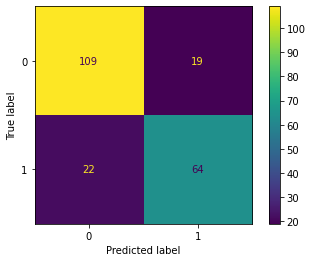

In [5]:
#confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred));
plot_confusion_matrix(logreg,X_test,y_test);

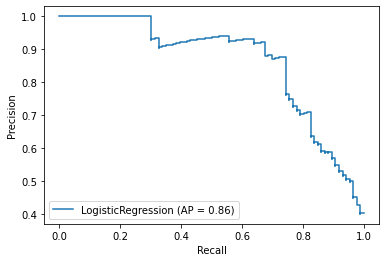

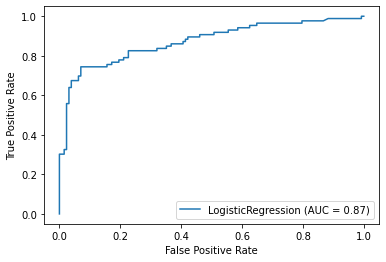

In [6]:
plot_precision_recall_curve(logreg,X_test,y_test);
plot_roc_curve(logreg,X_test,y_test);

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

## Read in the dataset

In [7]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

### Plotting function

In [8]:
def plot_number(X, y, ii, row, col):
    
    x1 = X[ii,:].reshape(28,28)
    for i in range(28):
        sns.scatterplot(x=np.linspace(0,27,28), 
                        y=np.ones(28)*27 - i, 
                        size=x1[i,:], legend=False,
                        ax=ax[row,col],color='k')
    sns.scatterplot(x=32, 
                    y=np.linspace(0,27,28),
                    size=reversed(x1.sum(axis=1)), legend=False,
                    ax=ax[row,col],color='k')
    sns.scatterplot(x=np.linspace(0,27,28), 
                    y=-5,
                    size=x1.sum(axis=0), legend=False,
                    ax=ax[row,col],color='k')
    ax[row,col].text(29, 15, 
             y[ii], 
             fontsize=14,
             verticalalignment='top', 
             horizontalalignment='center')

## Plot out some random entries to see what we're dealing with

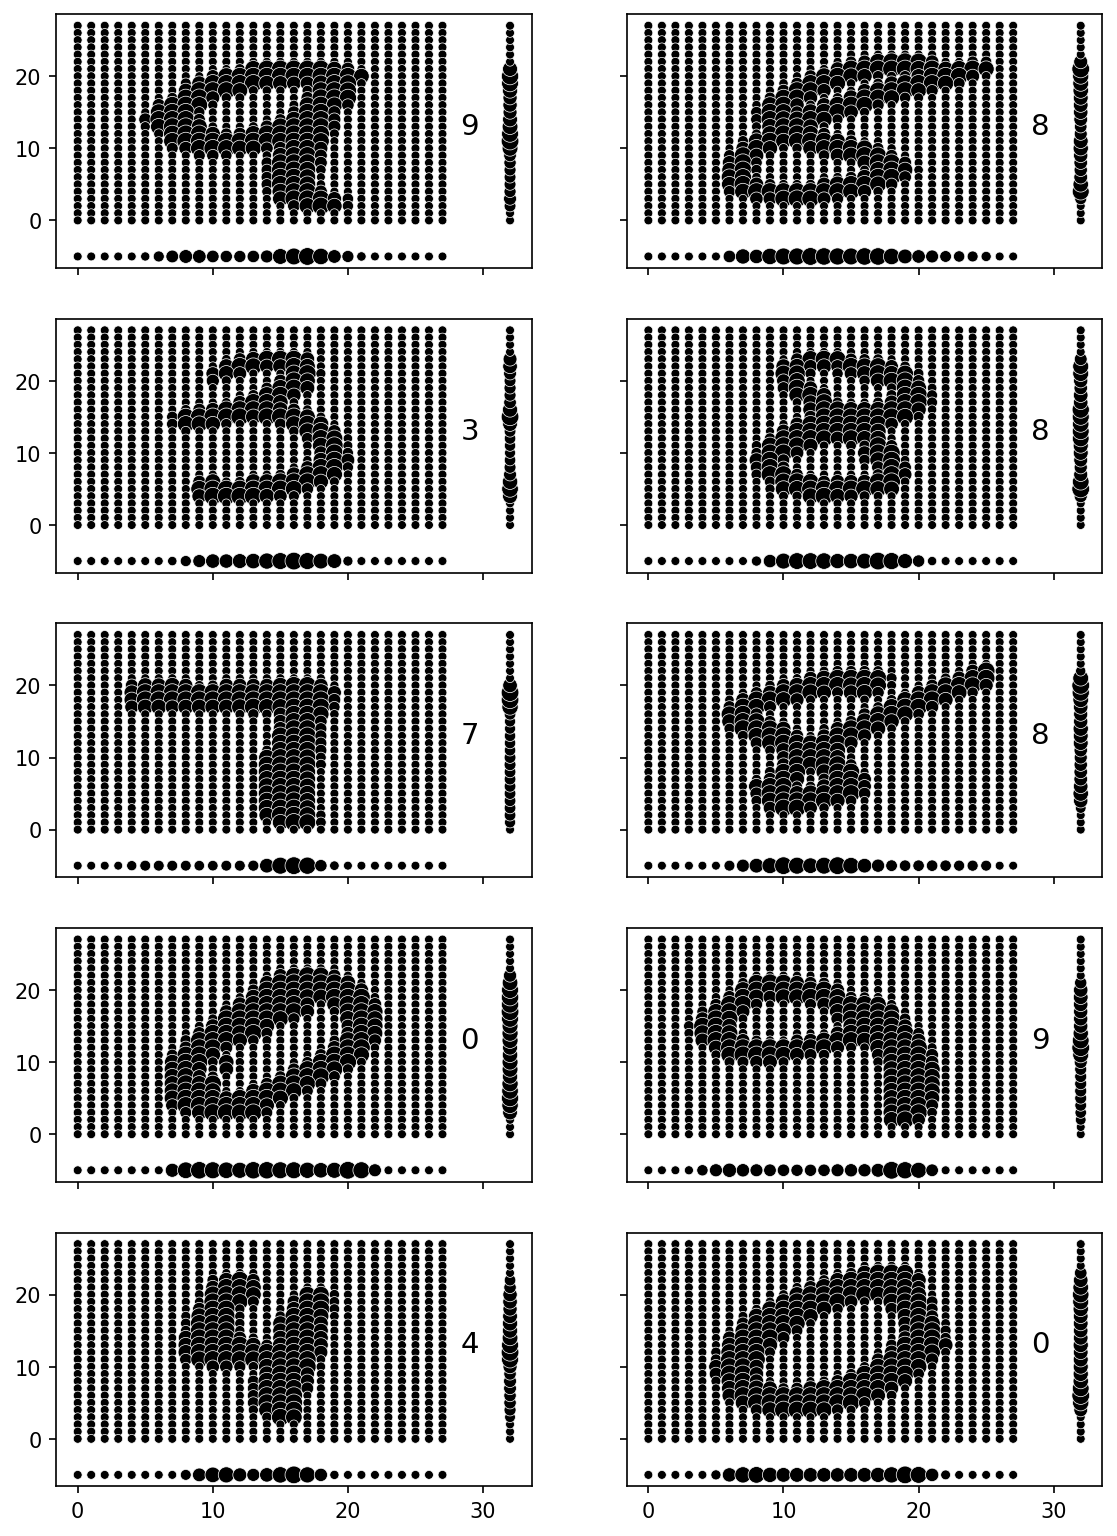

In [9]:
fig, ax = plt.subplots(5,2,dpi=150,figsize=(9,13),sharex='col',sharey='row')
chz = np.random.randint(70_000,size=10)
#chz = [12352,  6386,  7782, 27131, 49535,  5236,  3266,  5606, 52830, 44039]
cnt = 0
for i in chz:
    row = cnt // 2
    col = cnt % 2
    plot_number(X, y, i, row, col)
    cnt += 1

# Feature Engineering
## I decided to take the sums (like a "shadow") of the intensity at each pixel. I do this for each row (seen in the plots above, to the right of the pixelled number image) and each column (seen as the bottom (negative) row in the plots above).
<img src="Number_shadows.gif" width="750" align="center">

## In this fashion, I have abondoned the actual 28 x 28 pixels and will use only their sums to formulate the features.
## As well, I sum up the pixels diagonally. That is to say, across all of the downward-sloping diagonals when looking from left to right. Likewise for the upward-sloping diagonals from left to right.
## So the features are actually broken up into four sets of sums (some of them squared) to replicate "shadows" when looked at from the side, the bottom, and finally diagonally in boths senses.

In [27]:
# convert the data into the sums presented at the lhs and bottom of the plots below
X_alt = np.zeros((len(X), 111+28+27))
for i in range(len(X)):
    # reshape into the picture format 
    Xii = X[i,:].reshape(28,28)

    #======================================
    #  SUM OF ROWS AND COLUMNS
    #======================================
    
    # calculate the max sum's along rows and columns
    max_row = Xii.sum(axis=1).max()
    max_col = Xii.sum(axis=0).max()
    # get the sums and normalize to max values
    X_alt[i,:28] = Xii.sum(axis=1) / (max_row + 1.)
    X_alt[i,28:56] = Xii.sum(axis=0) / (max_col + 1.)
    
    #=======================================
    #  SUM OF DIAGONALS GOING UP FROM L-to-R
    #=======================================

    # sum up the diagonals that go down
    # to the right - start at top right
    # corner and go all the way to the
    # main diagonal
    for j in range(28):
        summ = 0
        for k in range(j+1):
            summ += Xii[j-k, 27-k]

        X_alt[i,56+j] = (summ * summ) / ((max_col+1) *(max_col+1)) * 3.
        
    # sum up the diagonals that go down
    # to the right - start at the bottom
    # left corner and go up to the diagonal
    # below the main one
    # NOTE: the entries in X_alt are done in
    # reverse order in order to maintain
    # the proper sequence of diagonals
    for j in range(27):
        summ = 0
        for k in range(j+1):
            summ += Xii[27-k, j-k]
                
        X_alt[i,56+28+26-j] = (summ * summ) / ((max_col+1) *(max_col+1)) * 3.

    #=======================================
    #  SUM OF DIAGONALS GOING DOWN FROM L-to-R
    #=======================================

    # sum up the diagonals that go UP
    # to the right - start at top left
    # corner and go all the way to the
    # main diagonal that stretches from
    # bottom left to top right.
    for j in range(28):
        summ = 0
        for k in range(j+1):
            summ += Xii[k, j-k]

        X_alt[i,56+28+27+j] = (summ * summ) / ((max_col+1) *(max_col+1)) * 2.
        
    # sum up the diagonals that go down
    # to the right - start at the bottom
    # left corner and go up to the diagonal
    # below the main one
    # NOTE: the entries in X_alt are done in
    # reverse order in order to maintain
    # the proper sequence of diagonals
    for j in range(27):
        summ = 0
        for k in range(j+1):
            summ += Xii[27-k, 27-j+k]
                
        X_alt[i,56+28+27+28+26-j] = (summ * summ) / ((max_col+1) *(max_col+1)) * 2.

# Plot the resulting (treated) "shadows"

In [46]:
arw_set = np.arange(7,22,3)
arrows = [list(x + arw_set) for x in [0, 28, 71, 123]]
arrows = [item for sublist in arrows for item in sublist]

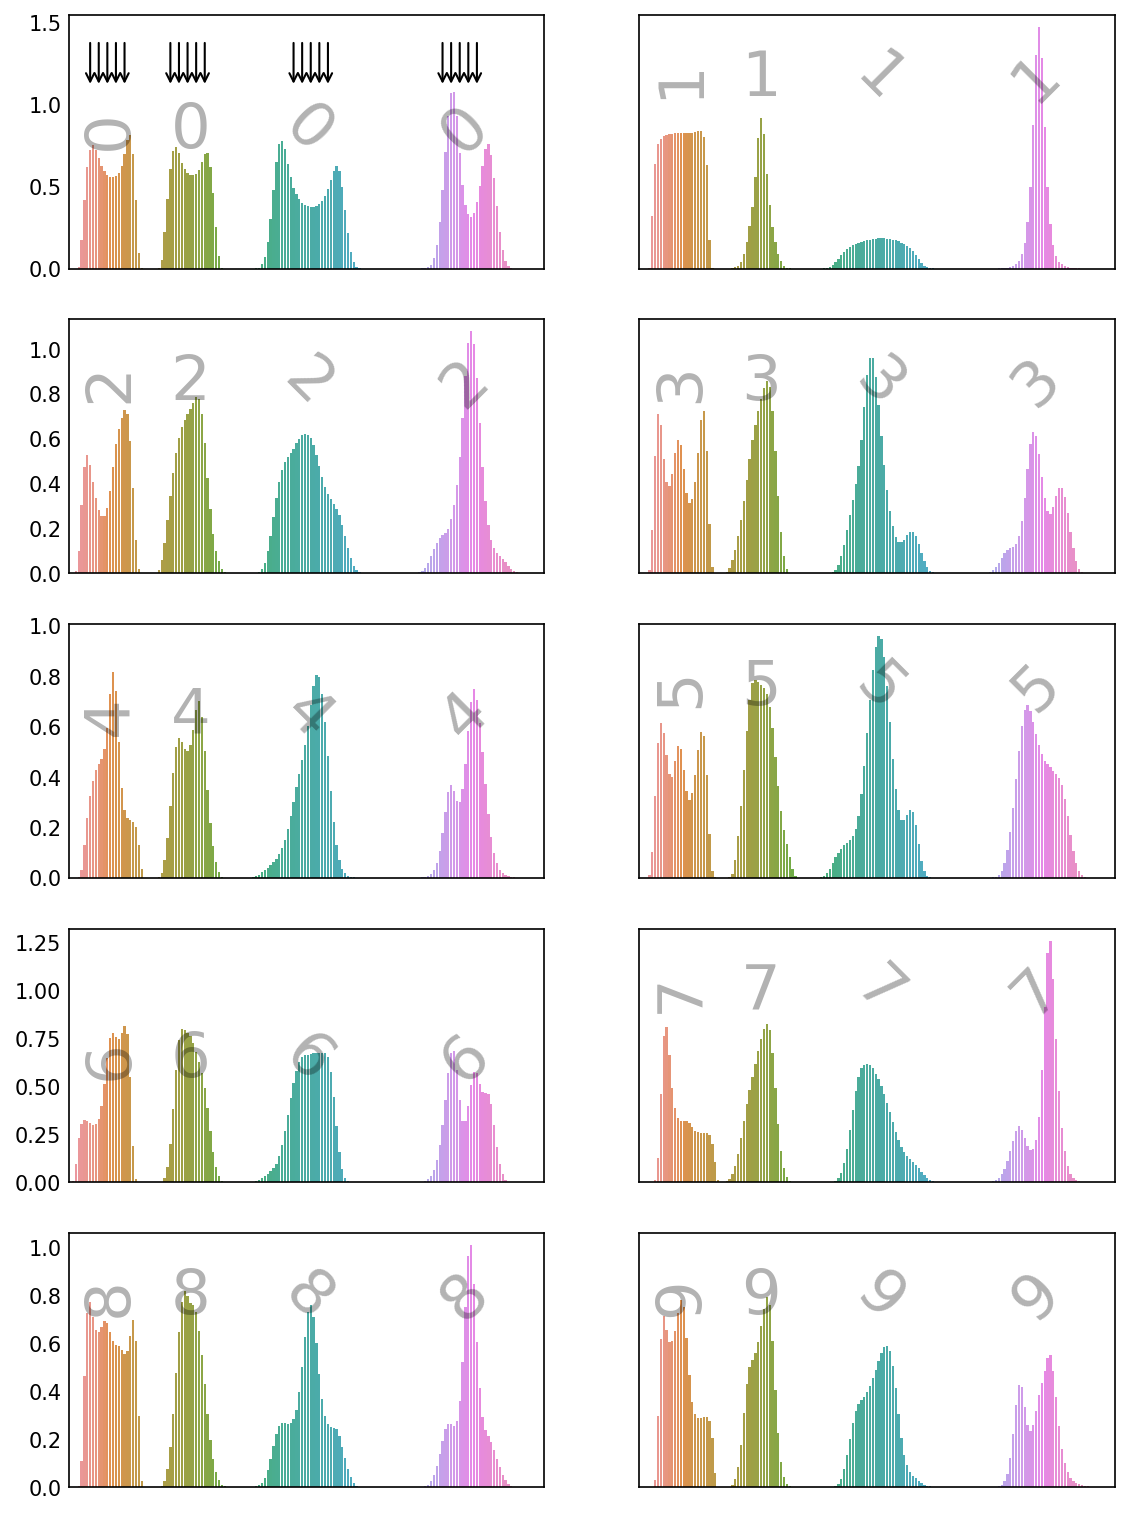

In [47]:
fig, ax = plt.subplots(5,2,dpi=150,figsize=(9,13),sharex='col',sharey='row')
lst = list(np.arange(10).astype(str))

cnt = 0
for num in lst:
    indx = (y == num)
    row = cnt // 2
    col = cnt % 2
    sns.barplot(x=np.linspace(0,166,166),y=X_alt[indx,:].mean(axis=0),ax=ax[row,col])
    ax[row,col].set_xticklabels([]);
    ax[row,col].tick_params(axis='both', which='both', length=0)
    ymin, ymax = ax[row, col].get_ylim()
    rots = [90, 0, -45, 45]
    xes = [14, 42, 83, 138]
    for i in range(len(rots)):
        ax[row,col].text(xes[i], ymax*0.75, 
             num, rotation = rots[i],
             fontsize=30, alpha = 0.3,
             verticalalignment='center', 
             horizontalalignment='center')
    if num == '0':
        for arw in arrows:
            ax[row,col].annotate("", xy=(arw, 1.1), xytext=(arw, 1.4),
                                 arrowprops=dict(arrowstyle="->"))
    cnt += 1

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_alt, y, test_size=10_000, random_state=101)

In [35]:
log_model = LogisticRegression(max_iter=5000, 
                               solver = 'saga', 
                               penalty = 'l1', # gets accuracy a slither better
                               n_jobs = 6 # not actually useful with 'ovr'
                               )
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=5000, n_jobs=6, penalty='l1', solver='saga')

In [36]:
y_pred = log_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'
      .format(log_model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.926


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1008
           1       0.96      0.98      0.97      1097
           2       0.93      0.92      0.92       989
           3       0.90      0.89      0.90      1046
           4       0.93      0.94      0.93       960
           5       0.90      0.87      0.89       913
           6       0.94      0.97      0.95      1005
           7       0.92      0.91      0.92      1068
           8       0.91      0.89      0.90       940
           9       0.89      0.90      0.89       974

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



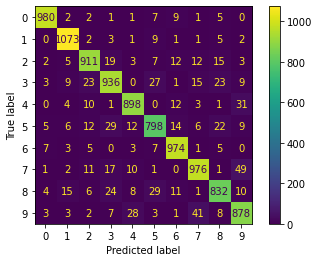

In [37]:
#confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred));
plot_confusion_matrix(log_model,X_test,y_test);

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [234]:
# read in the data
df = pd.read_csv('data/fish.csv')

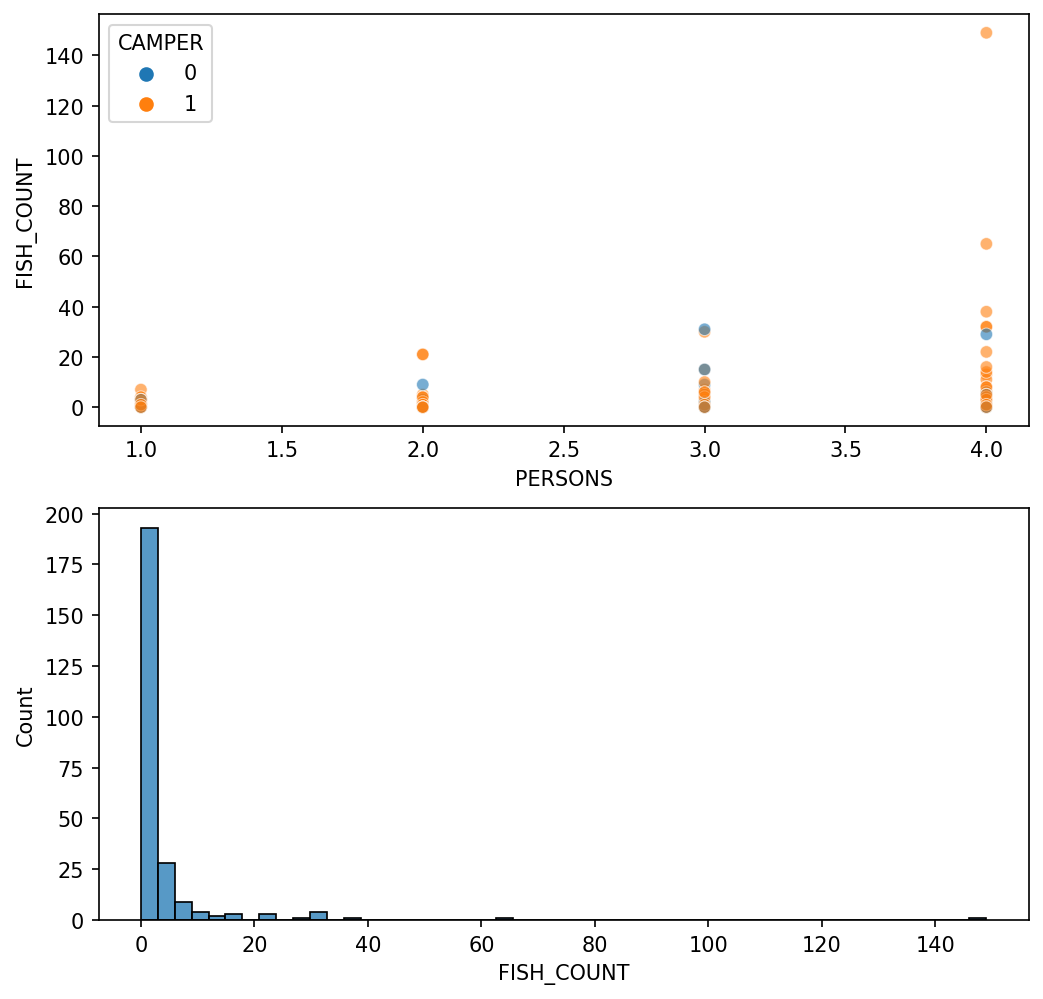

In [235]:
# look at the data
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150, figsize=(8,8))
sns.scatterplot(data=df, x='PERSONS', y='FISH_COUNT', hue='CAMPER', alpha=0.6, ax=ax1) 
sns.histplot(data=df,x='FISH_COUNT',bins=50,ax=ax2);

In [236]:
# create features and target
X = df.drop(columns=['FISH_COUNT']).copy()
X = sm.add_constant(X)
y = df['FISH_COUNT']

## First attempt with zero-inflated Poisson

In [237]:
# run Zero-Inflated Poisson as the first guess
est = sm.ZeroInflatedPoisson(y, X).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


D:\Users\Pinhead\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Sun, 07 Feb 2021   Pseudo R-squ.:                  0.3471
Time:                         17:02:26   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.278     -9.099      0.000      -3.078      -1.987
LIVE_BAIT         1.7086      0.242      7.073      0.000       1.235       2.182
CAMPER            0.6745      0.094      7.191      0.000       0.491       0.858
PERSONS           0.8752      0.043     20.447      0.000       0.791       0.959
CHILDREN         -1.3957      0.090    -15.582      0.000      -1.571      -1.220
=================================================================================
"""

The max fitted value is 6.6 c.f. real max of 149.


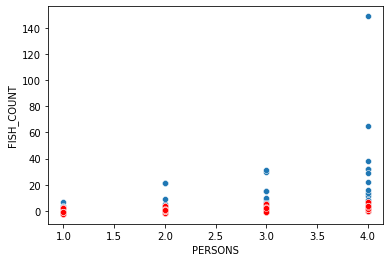

In [238]:
# compare fitted with actuals
sns.scatterplot(data=df, x='PERSONS', y='FISH_COUNT') 
sns.scatterplot(x=df.PERSONS, y=est.fittedvalues, color='red')
print(f"The max fitted value is {max(est.fittedvalues):.1f} c.f. real max of {max(y)}.")

## The fit is not very good: low predictions relative to target.

## Now do the two-stage approach
## <center/> Stage 1 </center>

In [239]:
# stage 1 : to a Logit fit for values greater than 0.
est1 = sm.Logit((y > 0).astype(int), X).fit()

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


In [240]:
# prep stage 2
X['stage1'] = est1.predict(X)
# check results of stage 1
confusion_matrix((y>0).astype(int), (est1.fittedvalues>0).astype(int))

array([[120,  22],
       [ 41,  67]], dtype=int64)

## Now do the two-stage approach
## <center/> Stage 2: Simple Model </center>

In [241]:
# feature engineering
X2 = X.copy()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sun, 07 Feb 2021   Prob (F-statistic):           2.90e-11
Time:                        17:02:35   Log-Likelihood:                -938.12
No. Observations:                 250   AIC:                             1888.
Df Residuals:                     244   BIC:                             1909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4807      2.556     -4.100      0.000     -15.516      -5.445
LIVE_BAIT      6.3331      2.468      2.566      0.011       1.471      11.195
CAMPER         6.9381      2.233      3.108      0.002       2.541      11.336
PERSONS        9.5638      2.288      4.180      0.000       5.058      14.070
CHILDREN     -14.1342      3.950     -3.578      0.000     -21.915      -6.353
stage1       -23.8062     10.774     -2.210      0.028     -45.028      -2.584
==============================================================================
Omnibus:                      420.458   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114163.931
Skew:                           8.715   Prob(JB):                         0.00
Kurtosis:                     106.228   Cond. No.                         57.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

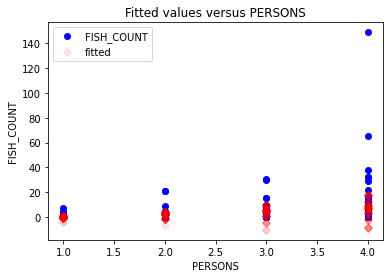

In [242]:
# run stage two
est2 = sm.OLS(y, X2).fit()
sm.graphics.plot_fit(est2, 3, vlines=False, alpha=0.1)
est2.summary()

The max fitted value is 18.0 c.f. real max of 149.


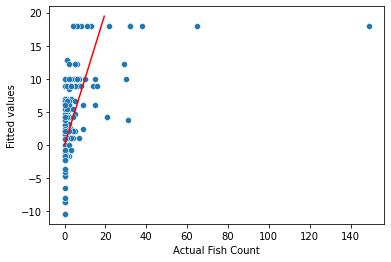

In [243]:
# compare fitted against actuals
ax = sns.scatterplot(data=df, x=y, y=est2.fittedvalues);
_, ymax = ax.get_ylim()
sns.lineplot(x=[0,ymax],y=[0,ymax],color='red');
plt.ylabel('Fitted values')
plt.xlabel('Actual Fish Count')
print(f"The max fitted value is {max(est2.fittedvalues):.1f} c.f. real max of {max(y)}.")

## The model is still lacking with just the plain features as is. The correlation is weak and the model cannot attain the high excursions in y. The 'const' is a -10 indicating the predominance of 0 fish catch. PERSONS, LIVE_BAIT and CAMPER all have positive influence on fish count whereas CHILDREN is negative (either they didn't fish or they stole fishing-time from the parents that wanted to fish).

## <center/> Stage 2: Complex Model with Better R-Squared but not really interpretable. </center>

In [252]:
# feature engineering
X3 = X.drop(columns=['CAMPER','CHILDREN','PERSONS','const'])
num_cols = ['stage1', 'PERSONS', 'CHILDREN'] 
for num in num_cols:
    X3[num+'2'] = X[num] ** 2
    X3[num+'3'] = X[num] ** 3
    X3['log_'+num] = X[num].apply(lambda x: np.log(1+x))
    X3[num+'2C'] = X[num] ** 2 * X['CAMPER'] 
    X3[num+'3C'] = X[num] ** 3 * X['CAMPER']
    X3['Clog_'+num] = X[num].apply(lambda x: np.log(1+x)) * X['CAMPER']
    X3[num+'2B'] = X[num] ** 2 * X['LIVE_BAIT']
    X3[num+'3B'] = X[num] ** 3 * X['LIVE_BAIT']
    X3['Blog_'+num] = X[num].apply(lambda x: np.log(1+x)) * X['LIVE_BAIT']
X3['PCC'] = X['PERSONS'] * X['CAMPER'] * X['CHILDREN']

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             FISH_COUNT   R-squared (uncentered):                   0.391
Model:                            OLS   Adj. R-squared (uncentered):              0.308
Method:                 Least Squares   F-statistic:                              4.713
Date:                Sun, 07 Feb 2021   Prob (F-statistic):                    5.16e-12
Time:                        17:04:50   Log-Likelihood:                         -915.38
No. Observations:                 250   AIC:                                      1891.
Df Residuals:                     220   BIC:                                      1996.
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
LIVE_BAIT         3.5288     36.527      0.097      0.923     -68.458      75.515
stage1          526.6752   6081.563      0.087      0.931   -1.15e+04    1.25e+04
stage12         -15.2182   2480.393     -0.006      0.995   -4903.591    4873.154
stage13        -120.1093    721.380     -0.166      0.868   -1541.809    1301.591
log_stage1     -692.1789   6236.149     -0.111      0.912    -1.3e+04    1.16e+04
stage12C        112.4113    215.737      0.521      0.603    -312.765     537.588
stage13C       -113.4326    177.075     -0.641      0.522    -462.414     235.548
Clog_stage1     -68.1458    185.267     -0.368      0.713    -433.271     296.979
stage12B       -223.8694    258.417     -0.866      0.387    -733.158     285.419
stage13B        206.0816    209.422      0.984      0.326    -206.649     618.812
Blog_stage1     130.3198    200.646      0.649      0.517    -265.115     525.755
PERSONS2          2.6983      7.330      0.368      0.713     -11.748      17.144
PERSONS3         -0.3300      1.321     -0.250      0.803      -2.934       2.274
log_PERSONS      18.5166     33.065      0.560      0.576     -46.647      83.680
PERSONS2C        -6.2557      7.759     -0.806      0.421     -21.548       9.036
PERSONS3C         1.6891      1.166      1.449      0.149      -0.608       3.986
Clog_PERSONS     34.8226     57.270      0.608      0.544     -78.045     147.690
PERSONS2B         1.6686     10.034      0.166      0.868     -18.107      21.445
PERSONS3B        -0.4155      1.712     -0.243      0.808      -3.790       2.959
Blog_PERSONS    -17.5010     52.771     -0.332      0.740    -121.502      86.500
CHILDREN2        -5.8101     13.363     -0.435      0.664     -32.146      20.526
CHILDREN3         1.3251      3.596      0.368      0.713      -5.762       8.412
log_CHILDREN    -25.3828     41.017     -0.619      0.537    -106.219      55.453
CHILDREN2C       11.3286     17.541      0.646      0.519     -23.240      45.898
CHILDREN3C       -1.5453      3.382     -0.457      0.648      -8.211       5.120
Clog_CHILDREN    -5.1730     40.329     -0.128      0.898     -84.654      74.308
CHILDREN2B        0.1526     16.319      0.009      0.993     -32.008      32.314
CHILDREN3B        0.1621      4.122      0.039      0.969      -7.961       8.285
Blog_CHILDREN    13.7900     45.076      0.306      0.760     -75.047     102.627
PCC              -9.5114      9.308     -1.022      0.308     -27.856       8.833
==============================================================================
Omnibus:                      398.977   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100773.599
Skew:                           7.846   P

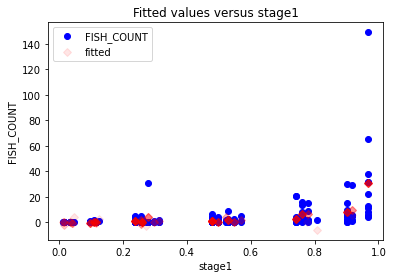

In [253]:
# run stage two
est3 = sm.OLS(y, X3).fit()
sm.graphics.plot_fit(est3, 1, vlines=False, alpha=0.1)
est3.summary()

The max fitted value is 31.2 c.f. real max of 149.


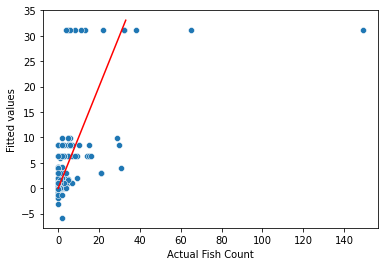

In [254]:
# compare fitted against actuals
ax = sns.scatterplot(data=df, x=y, y=est3.fittedvalues);
_, ymax = ax.get_ylim()
sns.lineplot(x=[0,ymax],y=[0,ymax],color='red');
plt.ylabel('Fitted values')
plt.xlabel('Actual Fish Count')
print(f"The max fitted value is {max(est3.fittedvalues):.1f} c.f. real max of {max(y)}.")

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

## 5.1: Streaming TV Churn

In [258]:
df = pd.read_csv('data/telco_churn.csv')
df.sample(8)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5401,5124-EOGYE,Male,0,No,No,31,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.45,638.55,No
3289,9626-VFRGG,Female,0,No,Yes,41,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),88.50,3645.05,No
1877,7873-CVMAW,Male,0,No,No,72,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),88.55,6362.35,No
5643,0231-LXVAP,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,Yes,No,No,Month-to-month,Yes,Electronic check,75.90,75.9,Yes
2522,0661-KBKPA,Male,0,Yes,Yes,53,Yes,Yes,DSL,No,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,78.75,3942.45,No
3544,8914-RBTSB,Male,0,Yes,No,31,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,No,Electronic check,93.80,3019.5,Yes
3638,7579-OOPEC,Female,1,Yes,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Credit card (automatic),50.15,115.1,Yes
1586,3766-EJLFL,Female,0,Yes,Yes,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.05,7508.55,No


In [259]:
df.StreamingTV.value_counts()

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

In [260]:
from lifelines import KaplanMeierFitter

In [261]:
T = df['tenure']
E = df['Churn'].map({'Yes':1, 'No':0})

kmf = KaplanMeierFitter()

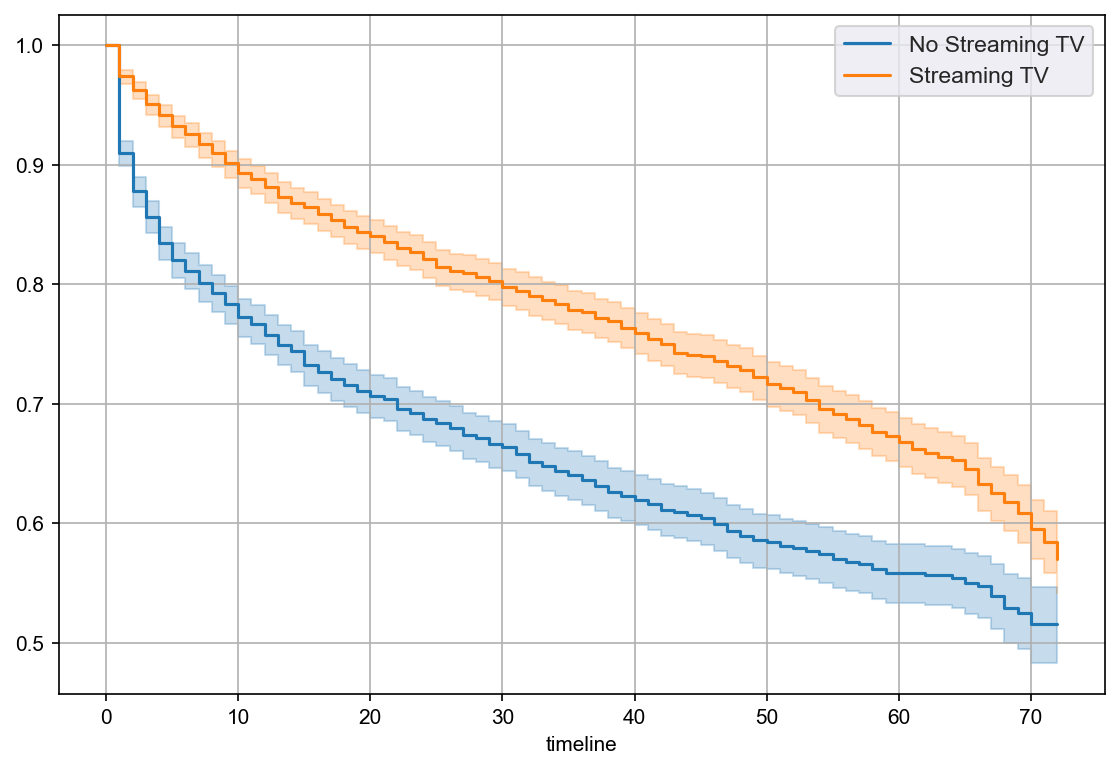

In [262]:
fig, ax = plt.subplots(dpi=150,figsize=(9,6))
sns.set()
groups = df['StreamingTV']
ix = (groups == 'Yes')
nx = (groups == 'No')
kmf.fit(T[nx], E[nx], label='No Streaming TV')
ax = kmf.plot_survival_function()
kmf.fit(T[ix], E[ix], label='Streaming TV')
ax = kmf.plot_survival_function(ax=ax)

## 5.2: Survival Regression Using Lifelines

In [263]:
from lifelines import CoxPHFitter

In [264]:
df = pd.read_csv('data/telco_churn.csv')

In [265]:
# drop useless column
df = df.drop(columns=['customerID','PhoneService',]) 

# convert to binaries
df['gender'] = df['gender'].map({'Male':1, 'Female':0})

# these will be strictly binary
to_bin = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn']

# these will be converted to dummy columns
to_dum = ['PaymentMethod', 'Contract']

# these have a redundancy with
# "InternetService" or "PhoneService" and so
# only the "yes" will be extracted.
to_yes = ['OnlineSecurity', 'TechSupport', 
          'StreamingMovies', 'StreamingTV',
          'OnlineBackup', 'DeviceProtection']

# let's not use PhoneService but use MultipleLines with 0, 1 and 2.
df['MultipleLines'] = (df['MultipleLines']
                       .map({'No phone service':0, 'No':1, 'Yes':2}))

# Likewise for InternetService
df['InternetService'] = (df['InternetService']
                       .map({'No':0, 'DSL':1, 'Fiber optic':2}))

# convert binaries
for col in to_bin:
    df[col] = df[col].map({'No':0, 'Yes':1})

# convert dummies
for col in to_dum:
    df_dum = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df, df_dum], axis=1)
    df = df.drop(columns=[col])

# convert only "yes" to 1
for col in to_yes:
    df[col] = df[col].apply(lambda x : x == 'Yes').map({True:1, False:0})
          

In [266]:
# TotalCharges has some values to fill for new clients
df.TotalCharges = pd.to_numeric(df.TotalCharges,errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(value=0)

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12686.05
         time fit was run = 2021-02-07 22:10:23 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
gender                                 -0.04       0.96       0.05            -0.13             0.05                 0.88                 1.05
SeniorCitizen                           0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
Partner                                -0.19       0.82       0.06            -0.30            -0.08                 0.74                 0.92
Dependents                             -0.10       0.91       0.07            -0.23             0.04                 0.79                 1.04
MultipleLines                          -0.03       0.97       0.08            -0.18             0.12                 0.83                 1.13
InternetService                         0.82       2.28       0.20             0.42             1.22                 1.53                 3.39
OnlineSecurity                         -0.22       0.80       0.07            -0.37            -0.08                 0.69                 0.93
OnlineBackup                           -0.13       0.88       0.06            -0.26            -0.01                 0.77                 0.99
DeviceProtection                        0.00       1.00       0.06            -0.12             0.12                 0.88                 1.13
TechSupport                            -0.12       0.89       0.07            -0.26             0.03                 0.77                 1.03
StreamingTV                             0.05       1.05       0.09            -0.12             0.23                 0.89                 1.25
StreamingMovies                         0.06       1.06       0.09            -0.11             0.23                 0.89                 1.26
PaperlessBilling                        0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
MonthlyCharges                          0.03       1.04       0.01             0.02             0.05                 1.02                 1.05
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
PaymentMethod_Credit card (automatic)  -0.00       1.00       0.09            -0.18             0.17                 0.83                 1.19
PaymentMethod_Electronic check          0.38       1.47       0.07             0.24             0.53                 1.27                 1.69
PaymentMethod_Mailed check              0.53       1.69       0.09             0.36             0.70                 1.43                 2.01
Contract_One year                      -1.39       0.25       0.10            -1.59            -1.19                 0.20                 0.30
Contract_Two year                      -4.02       0.02       0.19            -4.40            -3.64                 0.01                 0.03

                                           z      p   -log2(p)
covariate                                                     
gender                                 -0.88   0.38       1.40
SeniorCitizen                           0.54   0.59       0.77
Partner                                -3.50 <0.005      11.08
Dependents                             -1.39   0.17       2.59
MultipleLines                          -0.38   0.70       0.51
InternetService                         4.05 <0

None


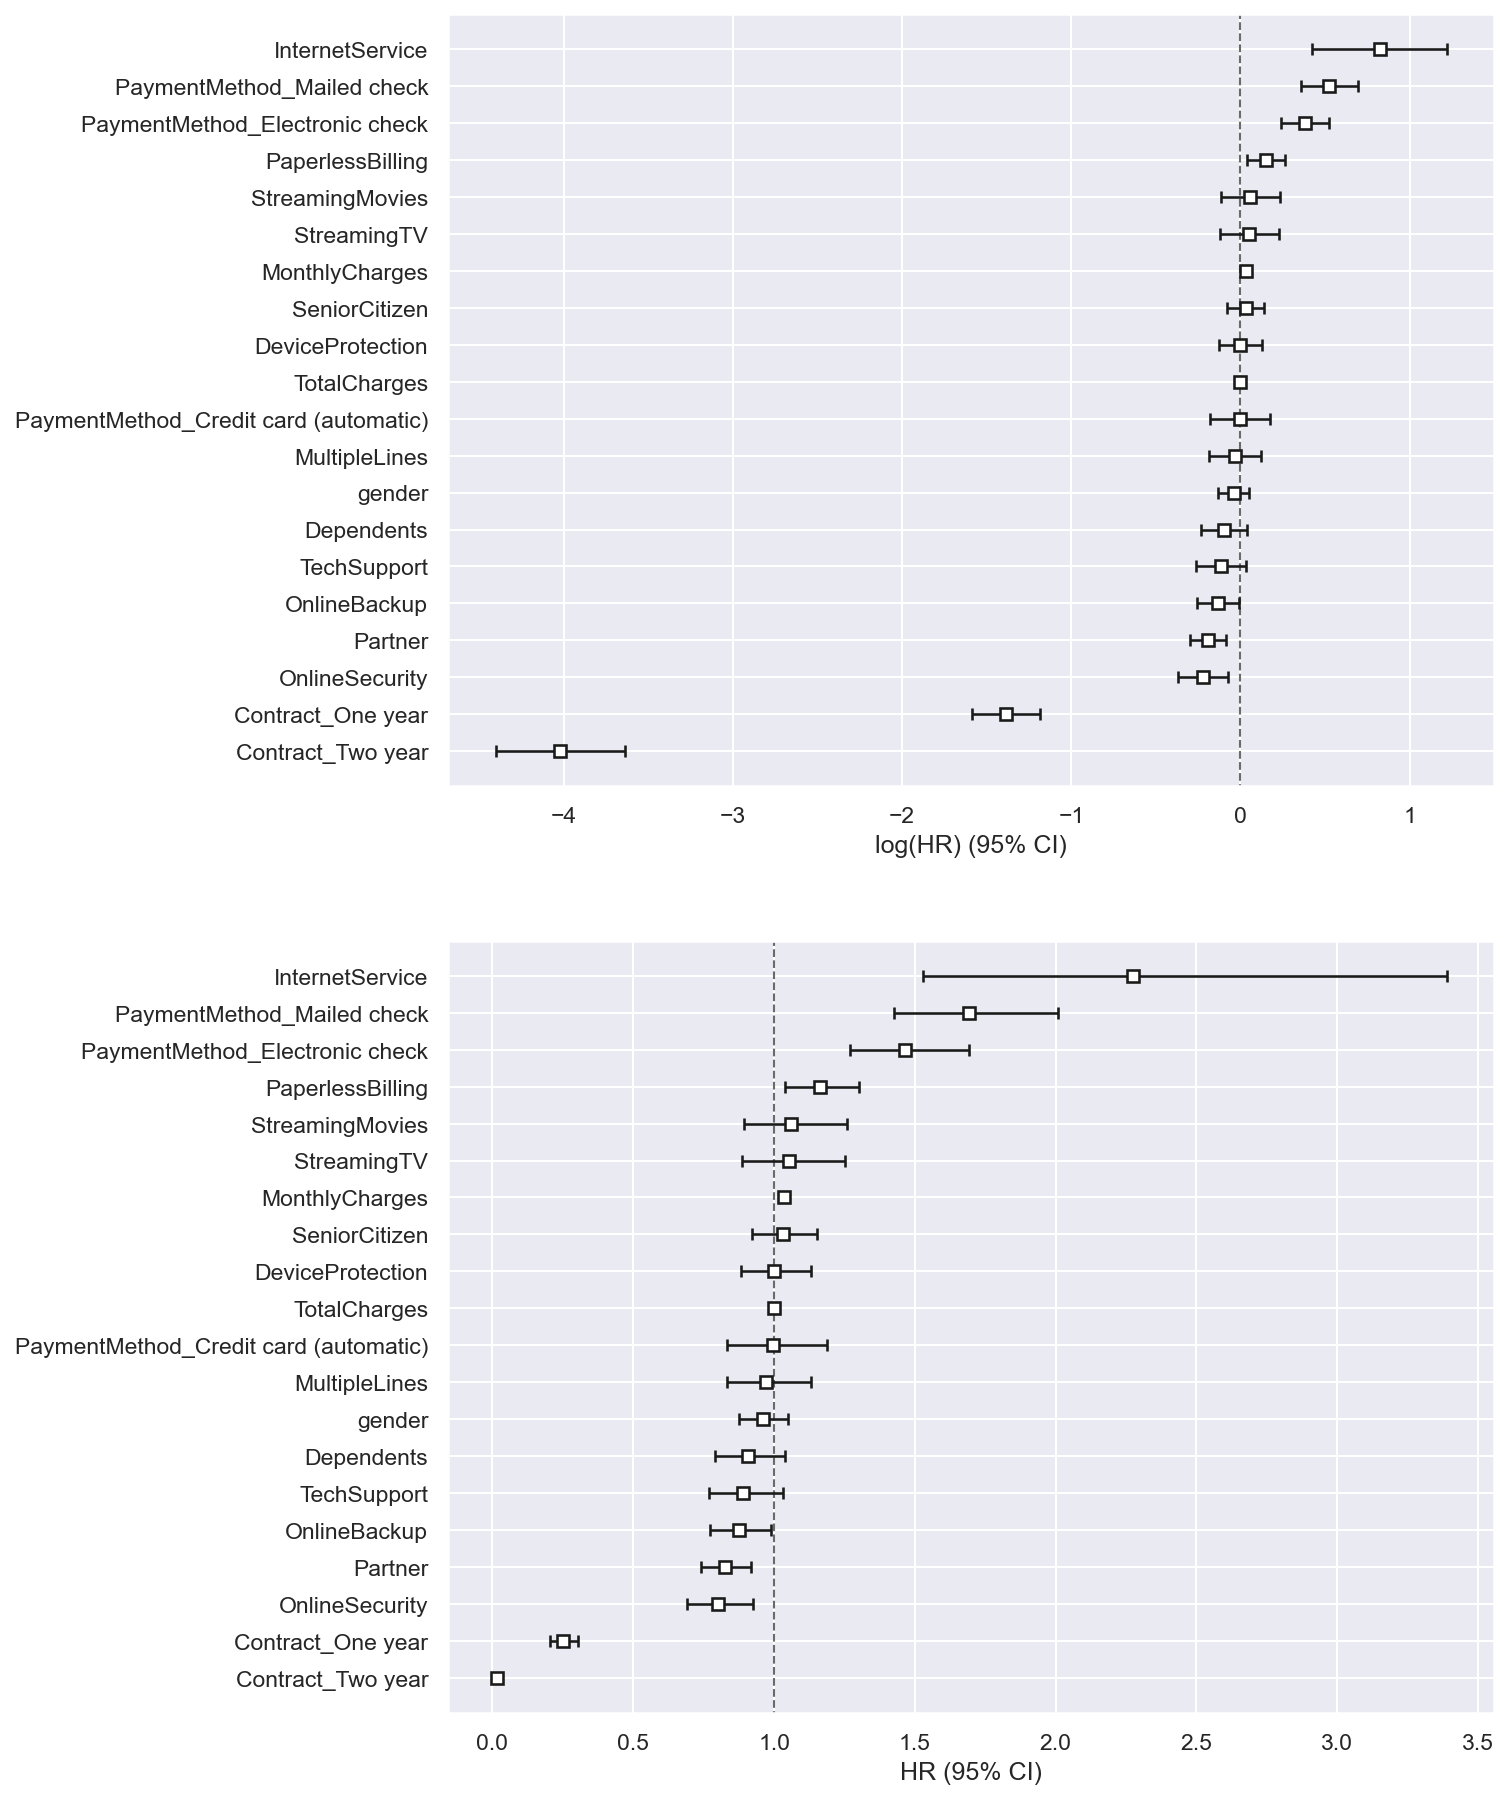

In [267]:
cph = CoxPHFitter()
cph.fit(df, duration_col='tenure', event_col='Churn')
print(cph.print_summary())
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150,figsize=(9,15))
cph.plot(hazard_ratios=False, ax=ax1);
cph.plot(hazard_ratios=True, ax=ax2);

## Analysis: the coefficients that have exp(coef) values that straddle 1 in their confidence intervals have a insigificant p-value. A value of 1 would indicate that they do not influence the hazard ratio (coefficient factors are multiplicative in this formulation). So the major contributors are the top four and bottom five in the graph above.

## 5.2: Survival Regression Using Statsmodels

In [268]:
y = df.tenure
X = df.drop(columns=['Churn', 'tenure'])
event = df.Churn

est = sm.PHReg(y, X, status=event).fit()
est.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: PHReg
============================================================================================
Model:                               PH Reg                 Sample size:                7032
Dependent variable:                  tenure                 Num. events:                1869
Ties:                                Breslow                                                
--------------------------------------------------------------------------------------------
                                       log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
--------------------------------------------------------------------------------------------
gender                                -0.0378    0.0465 0.9629  -0.8134 0.4160 0.8791 1.0547
SeniorCitizen                          0.0281    0.0566 1.0285   0.4970 0.6192 0.9205 1.1492
Partner                               -0.1825    0.0551 0.8331  -3.3115 0.0009 0.7478 0.9282
Dependents                            -0.1031    0.0698 0.9020  -1.4773 0.1396 0.7867 1.0343
MultipleLines                         -0.0198    0.0789 0.9804  -0.2510 0.8018 0.8400 1.1443
InternetService                        0.7880    0.2032 2.1990   3.8778 0.0001 1.4766 3.2749
OnlineSecurity                        -0.2103    0.0745 0.8103  -2.8227 0.0048 0.7002 0.9377
OnlineBackup                          -0.1167    0.0633 0.8898  -1.8428 0.0654 0.7860 1.0074
DeviceProtection                       0.0118    0.0638 1.0119   0.1852 0.8531 0.8930 1.1466
TechSupport                           -0.0966    0.0746 0.9080  -1.2938 0.1957 0.7844 1.0510
StreamingTV                            0.0606    0.0884 1.0625   0.6861 0.4927 0.8935 1.2635
StreamingMovies                        0.0681    0.0880 1.0705   0.7734 0.4393 0.9008 1.2721
PaperlessBilling                       0.1433    0.0569 1.1540   2.5193 0.0118 1.0323 1.2901
MonthlyCharges                         0.0330    0.0075 1.0335   4.4141 0.0000 1.0185 1.0488
TotalCharges                          -0.0015    0.0000 0.9985 -39.3881 0.0000 0.9984 0.9986
PaymentMethod_Credit card (automatic) -0.0023    0.0907 0.9977  -0.0255 0.9796 0.8351 1.1919
PaymentMethod_Electronic check         0.3654    0.0730 1.4411   5.0067 0.0000 1.2490 1.6627
PaymentMethod_Mailed check             0.5105    0.0871 1.6662   5.8602 0.0000 1.4046 1.9764
Contract_One year                     -1.3794    0.1012 0.2517 -13.6319 0.0000 0.2064 0.3069
Contract_Two year                     -3.9887    0.1941 0.0185 -20.5470 0.0000 0.0127 0.0271
============================================================================================
Confidence intervals are for the hazard ratios
"""

## Compare Lifelines and Statsmodels coefficients

In [270]:
df_summary = est.summary().tables[1][['log HR', 'HR']]
df_summary.columns = ['PHReg log HR', 'PHReg HR']
df_summary[['CPH log HR', 'CPH HR']] = cph.summary[['coef','exp(coef)']]
df_summary

,PHReg log HR,PHReg HR,CPH log HR,CPH HR
gender,-0.037797,0.962908,-0.040818,0.960004
SeniorCitizen,0.028123,1.028522,0.030754,1.031231
Partner,-0.182542,0.833149,-0.193003,0.824480
Dependents,-0.103110,0.902028,-0.096938,0.907612
MultipleLines,-0.019801,0.980394,-0.029873,0.970569
InternetService,0.787997,2.198989,0.822558,2.276315
OnlineSecurity,-0.210300,0.810341,-0.221838,0.801045
OnlineBackup,-0.116709,0.889844,-0.132641,0.875779
DeviceProtection,0.011807,1.011877,0.000015,1.000015
TechSupport,-0.096560,0.907956,-0.115755,0.890694
